In [1]:
import sys,os
sys.path.insert(0,'/global/project/projectdirs/metatlas/anaconda/lib/python2.7/site-packages' )
from metatlas import metatlas_objects as metob
import csv


curr_ld_lib_path = ''

os.environ['LD_LIBRARY_PATH'] = curr_ld_lib_path + ':/project/projectdirs/openmsi/jupyterhub_libs/boost_1_55_0/lib' + ':/project/projectdirs/openmsi/jupyterhub_libs/lib'
import sys
# sys.path.remove('/anaconda/lib/python2.7/site-packages')
sys.path.append('/global/project/projectdirs/openmsi/jupyterhub_libs/anaconda/lib/python2.7/site-packages')
sys.path.insert(0,'/project/projectdirs/openmsi/projects/meta-iq/pactolus/pactolus' )

from rdkit import Chem
# from rdkit.Chem.rdMolDescriptors import ExactMolWt
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import Draw

from rdkit import DataStructs
import numpy as np

from matplotlib import pylab as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import networkx as nx


In [2]:
import pickle
with open('save_compound_data_0_no_Hs.pkl', 'rb') as handle:
    compoundData = pickle.load(handle)
with open('save_cluster_data_all_no_Hs.pkl', 'rb') as handle:
    clusterData = pickle.load(handle)

In [ ]:
# ncluster = 200
# kmsample = 1000  # 0: random centres, > 0: kmeanssample
# kmdelta = .00001
# kmiter = 10
# metric = "rogerstanimoto"  # "chebyshev" = max, "cityblock" L1,  Lqmetric
# seed = 1
# centers, cluster, dist = kmeanssample( compoundData['fingerprint_mat'], ncluster, nsample=kmsample,
#             delta=kmdelta, maxiter=kmiter, metric=metric, verbose=2 )

In [ ]:
# from scipy.cluster.vq import kmeans, vq
# numClusters = 3
# centers, _ = kmeans(norm_fingerprint_mat[:99,:], numClusters, iter=1)
# cluster, _ = vq(fingerprint_mat[:99,:], centers)

In [ ]:
np.sum(compoundData['fingerprint_mat'][3562,:])

In [ ]:
# idx = []
# for i, val in enumerate(compoundData['myName']):
#     if 'leucine' in val:
#         idx.append(i)
# for i in idx:
#     print i,compoundData['myName'][i]

idx_lysine = 5788
idx_acetyl_lysine = 1136
idx_D_lysine = 10746
idx_dehydrolysine = 5638
idx_leucine = 823
# print square_dists[idx_lysine,idx_acetyl_lysine]
# print cluster[idx_lysine]
# print cluster[idx_acetyl_lysine]
print "Lysine to Acetyl-Lysine = ", compoundData['fingerprint_dists'][idx_acetyl_lysine,idx_lysine]
print "D to L lysine = ", compoundData['fingerprint_dists'][idx_lysine,idx_D_lysine]

In [ ]:
# # from scipy.spatial.distance import squareform

# y,edges = np.histogram(clusterData['distance'], bins=3333)
# plt.semilogy(edges[:-1],y)
# plt.show()

In [4]:
cutoff = 0.1
from scipy.cluster.hierarchy import fcluster,maxRstat, inconsistent,maxinconsts
# R = inconsistent(clusterData['linkage'])
# MR = maxRstat(clusterData['linkage'], R, 3)
# MI = maxinconsts(clusterData['linkage'], R)
# cluster = fcluster(clusterData['linkage'], t=10000, criterion='maxclust_monocrit', monocrit=MI)
# cluster = fcluster(clusterData['linkage'], t=1.154, criterion='monocrit', monocrit=MR)
# cluster = fcluster(clusterData['linkage'],cutoff,criterion='distance') - 1
# cluster = fcluster(clusterData['linkage'],1.1547,criterion='inconsistent') - 1
cluster = fcluster(clusterData['linkage'],1000,criterion = 'maxclust') - 1 #,criterion='inconsistent') - 1
#1.155 is 1
#1.154 is 2006
uCluster = np.unique(cluster)
numClusters = len(uCluster)
numCompounds = len(cluster)
clustSize = []
for u in uCluster:
    clustSize.append( len(np.argwhere( cluster == u ).flatten()) )
print numClusters, numCompounds
# print cluster[idx_lysine], cluster[idx_acetyl_lysine], cluster[idx_D_lysine], cluster[idx_dehydrolysine], cluster[idx_leucine]
# plt.hist(clustSize,100)
# plt.show()

1000 15395


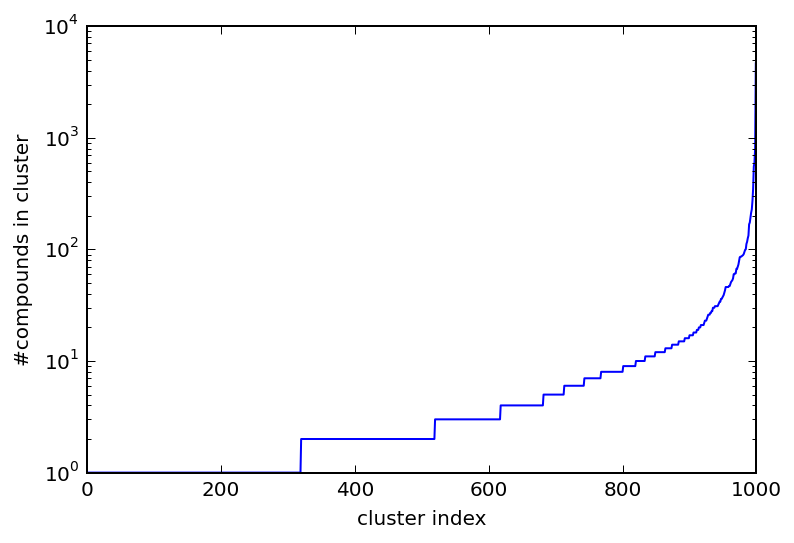

In [5]:
plt.semilogy(np.sort(clustSize))
plt.xlabel('cluster index')
plt.ylabel('#compounds in cluster')
plt.show()

In [6]:
# find the average molecule in each cluster
# this will help understand the clusters
# this will help score differences between clusters
f = open("20151217_clusters_maxclust_1000_no_Hs.txt", 'w')
from scipy.spatial.distance import squareform
square_compound_dists = squareform(squareform(squareform(clusterData['distance'])))
clusterConsensusID = []

for i,u1 in enumerate(uCluster):
    idx1 = np.argwhere(cluster == u1).flatten()
    fp = compoundData['fingerprint_mat'][idx1,:]
    mfp = np.mean(fp.astype(float),axis = 0)
    d = []
    for j in range(len(idx1)):
        d.append(np.linalg.norm(mfp-fp[j,:]))
    idx = np.argmin(d).flatten()
    idx_max = np.argmax(d).flatten()
    clusterConsensusID.append(idx1[idx])
    f.write("consensus molecules is : %s\n"%compoundData['myName'][idx1[idx]])
    deviation = float(np.max(d))/sum(mfp)
    f.write("minimumm deviation from average is %d\n"%d[idx])
    f.write("maximum deviation from average is %d\n"%d[idx_max])
    f.write("number of bits in average fingerprint is %d\n"%sum(mfp))
    for j in range(len(idx1)):
        f.write( "Distance from consensus = %5.5f. Cluster %d #%d is %s\n"%(square_compound_dists[idx1[idx],idx1[j]],i,j,compoundData['myName'][idx1[j]] ))
    f.write('\n')
f.close()
#     d_list = []
#     for m,i1 in enumerate(idx1):
#         
#         d_list.append(compoundData['fingerprint_dists'][i1,i2])
            # clusterDist[i,j] = np.mean(d_list)
    

In [8]:
clusterDist = np.zeros((len(uCluster),len(uCluster)))
for i,u1 in enumerate(clusterConsensusID):
    for j,u2 in enumerate(clusterConsensusID):
        if i>j:
            clusterDist[i,j] = square_compound_dists[u1,u2]
clusterDist

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.66666667,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.66666667,  0.8       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 1.        ,  1.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  0.        ]])

In [113]:
# leucine is in cluster 289 has tryptophan and indole-modifications and cluster #290 is indole
clusterDist[290,289]

0.69724770642201839

In [9]:

multiplier = 100
G=nx.Graph()

e0 = []
e1 = []

#TODO: ADD NODE SIZE FOR HOW MANY COMPOUNDS

for i in range(len(uCluster)):
    G.add_node('%d'%i)
    temp = clusterDist[i,0:i]
    if len(temp)>1:
        m = np.sort(temp)
        for j in range(i):
            if clusterDist[i,j]<=m[0] and clusterDist[i,j]<0.8:
                G.add_edge('%d'%i,'%d'%j, weight = (1./(0.001 + clusterDist[i,j])*multiplier) )
                e0.append(('%d'%i,'%d'%j))

connected_graphs = sorted(nx.connected_components(G),key=len)
print len(connected_graphs)

# while len(connected_graphs) > 1:
#     for i,cc1 in enumerate(connected_graphs):
#         source = []
#         target = []
#         distance = []
#         for j,cc2 in enumerate(connected_graphs):
#             if i != j:
#                 for s in cc1:
#                     for t in cc2:
#                         source.append(s)
#                         target.append(t)
#                         distance.append(clusterDist[int(s),int(t)])
#     idx = np.argmin(distance)
#     G.add_edge(source[idx],target[idx], weight = (1./(0.001 + distance[idx])*multiplier) )
#     e1.append((source[idx],target[idx]))
#     connected_graphs = sorted(nx.connected_components(G),key=len)
        
# ealpha = np.linspace(0,0.3,8)
# e0=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] < ealpha[0]*multiplier]
# e1=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >= ealpha[0]*multiplier and d['weight'] < ealpha[1]*multiplier]
# e2=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >= ealpha[1]*multiplier and d['weight'] < ealpha[2]*multiplier]
# e3=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >= ealpha[2]*multiplier and d['weight'] < ealpha[3]*multiplier]
# e4=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >= ealpha[3]*multiplier and d['weight'] < ealpha[4]*multiplier]
# e5=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >= ealpha[4]*multiplier and d['weight'] < ealpha[5]*multiplier]
# e6=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >= ealpha[5]*multiplier and d['weight'] < ealpha[6]*multiplier]
# e7=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >= ealpha[6]*multiplier and d['weight'] < ealpha[7]*multiplier]
# e8=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >= ealpha[7]*multiplier]




96


In [10]:
labels = {}
for node in G.nodes():
    labels[node] = compoundData['myName'][clusterConsensusID[int(node)]]

#also type can be circle or square    
nx.set_node_attributes(G, 'name', labels)

<IPython.core.display.Javascript object>


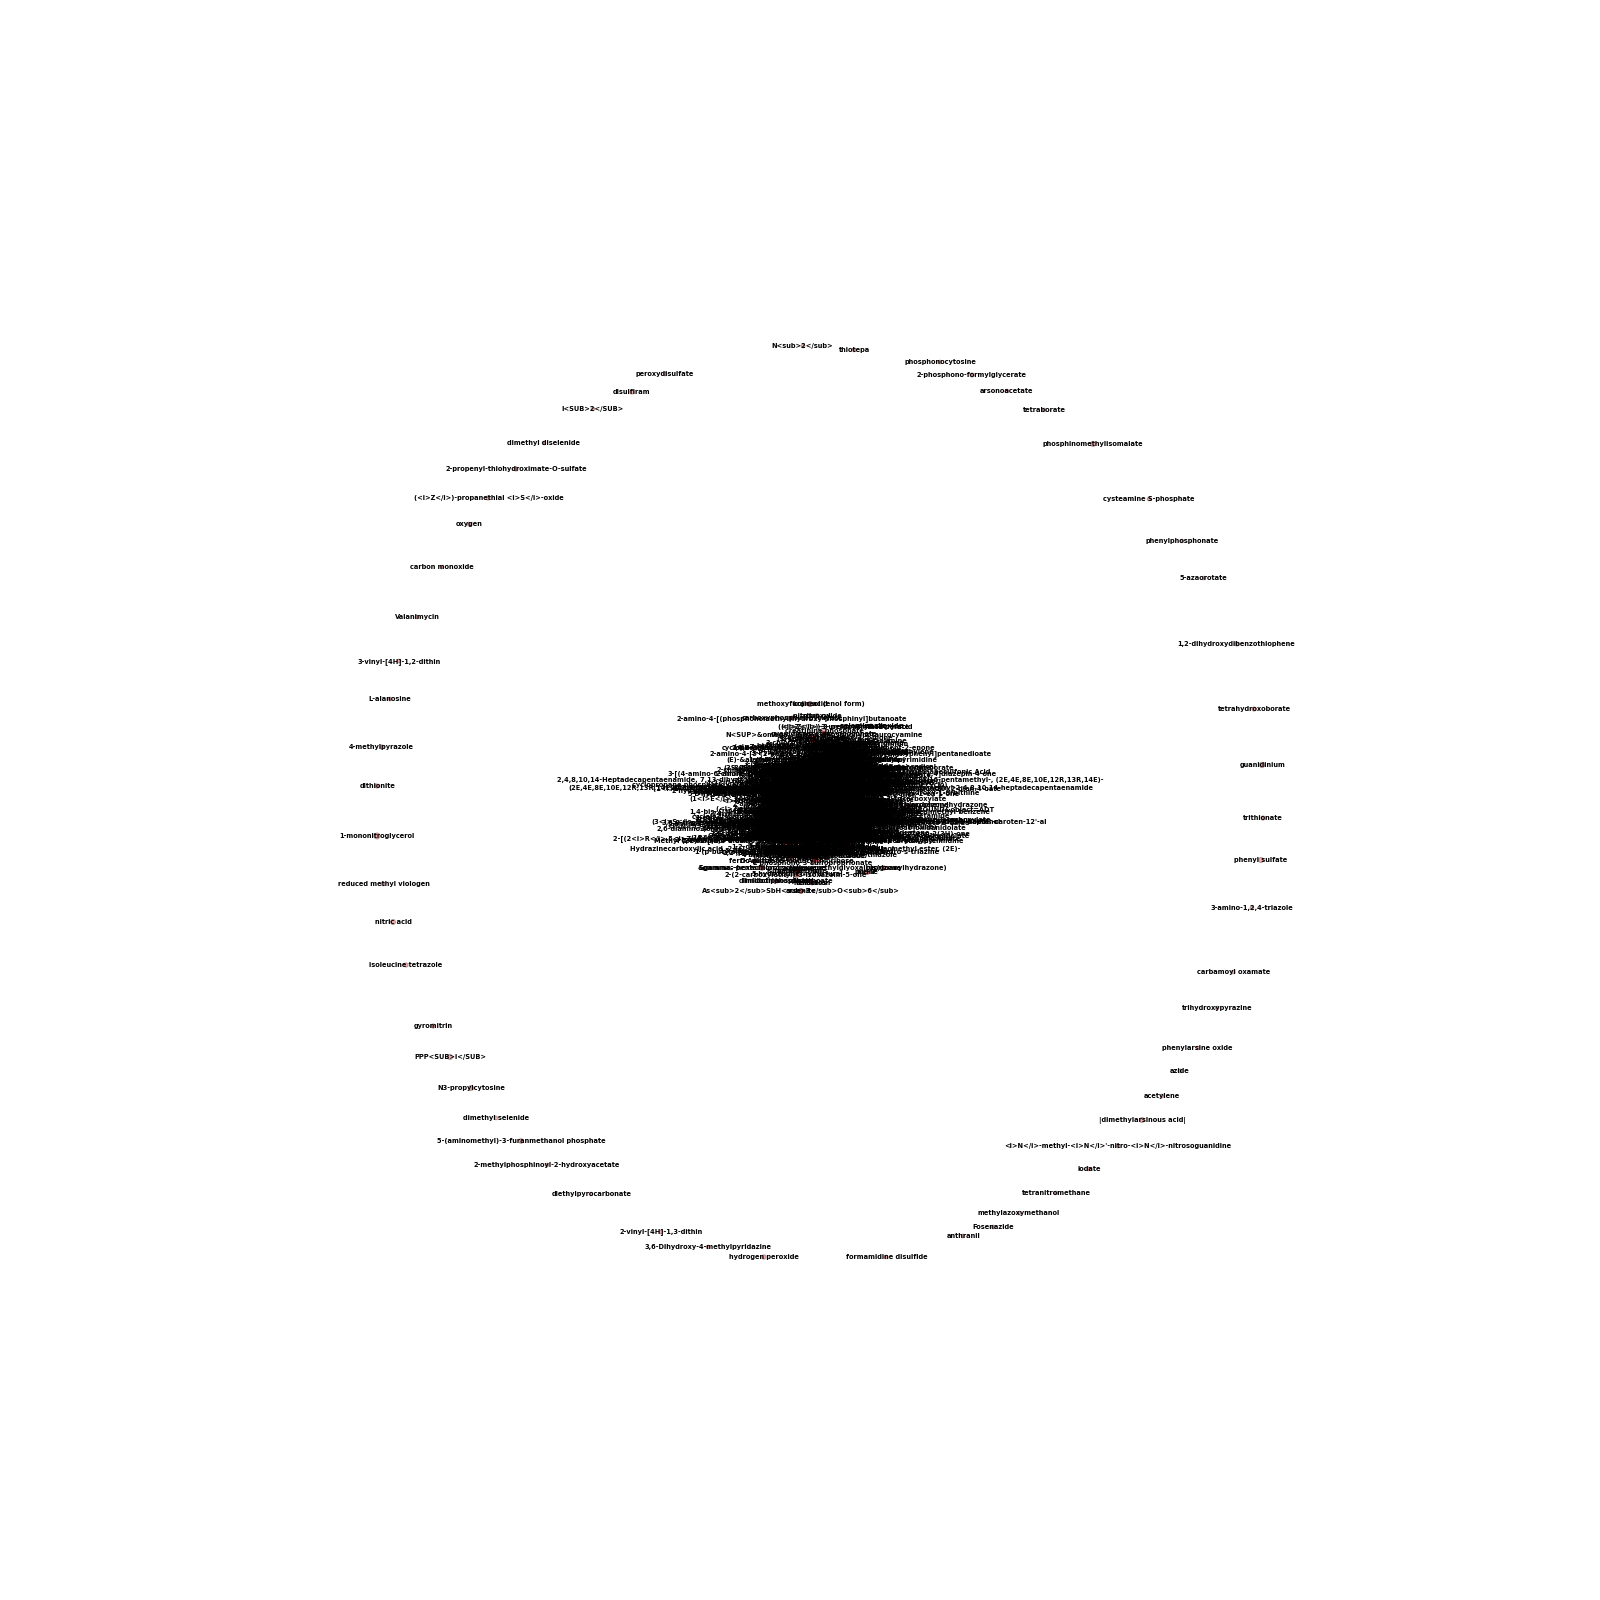

/global/project/projectdirs/metatlas/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)

pos=nx.spring_layout(G,iterations=50,k=0.01)

node_dict = G.node
for i,k in enumerate(node_dict.keys()):
    nx.draw_networkx_nodes(G,pos,with_labels=False,
                       nodelist=[k],
                       node_color='r',
                       node_size=10*len(np.argwhere(cluster == int(k)))**0.5,
                   alpha=0.3)



#Now only add labels to the nodes you require (the hubs in my case)
# nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='r')

nx.draw_networkx_edges(G,pos,edgelist=e0,
                    width=3,alpha = 0.7, edge_color = 'r')
nx.draw_networkx_edges(G,pos,edgelist=e1,
                    width=3,alpha = 0.3, edge_color = 'g')
# nx.draw_networkx_edges(G,pos,edgelist=e2,
#                     width=3,alpha = 0.7, edge_color = 'g')
# nx.draw_networkx_edges(G,pos,edgelist=e3,
#                     width=3,alpha = 0.6, edge_color = 'g')
# nx.draw_networkx_edges(G,pos,edgelist=e4,
#                     width=3,alpha = 0.5, edge_color = 'r')
# nx.draw_networkx_edges(G,pos,edgelist=e5,
#                     width=3,alpha = 0.4, edge_color = 'r')
# nx.draw_networkx_edges(G,pos,edgelist=e6,
#                     width=3,alpha = 0.3, edge_color = 'r')
# nx.draw_networkx_edges(G,pos,edgelist=e7,
#                     width=3,alpha = 0.2, edge_color = 'r')
# nx.draw_networkx_edges(G,pos,edgelist=e8,
#                     width=3,alpha = 0.1, edge_color = 'r')


# nx.draw_networkx_edges(G,pos,edgelist=esmall,
#                     width=3,alpha=0.25,edge_color='g')#,style='dashed')

# nx.draw_networkx_edges(G,pos,
#                        width=2,alpha=0.25,edge_color='r')

nx.draw_networkx_labels(G,pos,labels,ax=ax,font_size=6,font_weight='bold')

# ax.set_title('click on points')

# line, = ax.plot(np.random.rand(100), 'o', picker=5)  # 5 points tolerance

plt.axis('off')

plt.show()

In [12]:
from networkx.readwrite import json_graph
import json
d = json_graph.node_link_data(G) # node-link format to serialize
# write json
json.dump(d, open('20151217_myNetwork_0p9_cutoff.json','w'))

In [ ]:
s = 5
t = 8
print square_dists[s,t]
print sum(centers[s,:])
print sum(centers[t,:])

In [ ]:
idx = np.argwhere(cluster==2) #42 58
for i in idx:
    print compoundData['myName'][i], compoundData['myMW'][i], np.sum(compoundData['fingerprint_mat'][i,:])
# myName[idx]
# print fingerprint_mat.shape

In [ ]:
idx1 = 2945
idx2 = 168
test_d = DataStructs.FingerprintSimilarity(fps[idx1],fps[idx2])
print myNames[idx1]," ",myNames[idx2], test_d
print pd[idx1,idx2]


In [ ]:
# s = np.sum(pd==0.0,1)
# idx1 = np.argsort(s)[::-1]

# checker = 0+18

# print idx1[checker], myNames[idx1[checker]]
# idx2 = np.argwhere(pd[idx1[checker],:]==0.0)
# for i,idx in enumerate(idx2):
#     print i, idx, myNames[idx], pd[checker,idx],pd[idx1[checker],idx[0]]
# #     idx2 = np.argwhere(pd[i,:]>=1)
# #     for j in idx2:
# #         print i,j,myNames[j],pd[i,j]

#Identify sets of compounds that are identical by Tanimoto coefficient

In [ ]:
fid = open('MetAtlas_Network_unity.tab','w')
for i in range(pd.shape[0]):
    for j in range(pd.shape[1]):
        if i<j:
            if pd[i,j]==1:
                fid.write('"#%d %s"\t"#%d %s"\t%5.5f\n' % (i,
                                                           myNames[i],
                                                           j,
                                                           myNames[j],
                                                           pd[i,j]))
#         print i, idx, myNames[idx], pd[checker,idx],pd[idx1[checker],idx[0]]
#     pd_row = pd[i,:]
#     m = np.max(pd_row)
#     if m==1:
#     idx = np.argwhere( pd_row == 1.0 )
#     for j in idx:
#         if j!=i:
#             fid.write('"%d%s"\t"%d%s"\t%5.5f\n' % (i,myNames[i],j,myNames[j],pd_row[j]))
fid.close()

#Make network of most similar metabolites

In [ ]:
fid = open('MetAtlas_Network_Similar.tab','w')
for i in range(pd.shape[0]):
    temp = pd[i,0:i]
    if len(temp)>1:
        m = min(temp)
        if m<100000:
            for j in range(i-1):
                if pd[i,j]==m:
                    fid.write('"#%d %s %5.4f %s"\t"#%d %s %5.4f %s"\t%5.5f\n' % (i,
                                                                                 myformula[i],
                                                                                 myMW[i],
                                                                                 myNames[i],
                                                                                 j,
                                                                                 myformula[j],
                                                                                 myMW[j],
                                                                                 myNames[j],
                                                                                 pd[i,j]))
    
#     m = max(pd[i,:])
# #     if m == 1:
#     for j in range(pd.shape[1]):
#         if i<j:
#             if pd[i,j]==m:
#                 fid.write('"#%d %s %5.4f %s"\t"#%d %s %5.4f %s"\t%5.5f\n' % (i,
#                                                                                  myformula[i],
#                                                                                  myMW[i],
#                                                                                  myNames[i],
#                                                                                  j,
#                                                                                  myformula[j],
#                                                                                  myMW[j],
#                                                                                  myNames[j],
#                                                                                  pd[i,j]))
#         print i, idx, myNames[idx], pd[checker,idx],pd[idx1[checker],idx[0]]
#     pd_row = pd[i,:]
#     m = np.max(pd_row)
#     if m==1:
#     idx = np.argwhere( pd_row == 1.0 )
#     for j in idx:
#         if j!=i:
#             fid.write('"%d%s"\t"%d%s"\t%5.5f\n' % (i,myNames[i],j,myNames[j],pd_row[j]))
fid.close()

In [ ]:
fid = open('Tanimoto_2048_MetAtlas_Network_Cutoff_Min_Match_100.tab','w')
for i in range(pd.shape[0]):
    temp = pd[i,0:i]
    if len(temp)>1:
        m = min(temp)
        if m<100:
            for j in range(i-1):
                if pd[i,j]==m:
                    fid.write('"#%d %s %5.4f %s"\t"#%d %s %5.4f %s"\t%5.5f\n' % (i,
                                                                                 myformula[i],
                                                                                 myMW[i],
                                                                                 myNames[i],
                                                                                 j,
                                                                                 myformula[j],
                                                                                 myMW[j],
                                                                                 myNames[j],
                                                                                 pd[i,j]))
#         print i, idx, myNames[idx], pd[checker,idx],pd[idx1[checker],idx[0]]
#     pd_row = pd[i,:]
#     m = np.max(pd_row)
#     if m==1:
#     idx = np.argwhere( pd_row == 1.0 )
#     for j in idx:
#         if j!=i:
#             fid.write('"%d%s"\t"%d%s"\t%5.5f\n' % (i,myNames[i],j,myNames[j],pd_row[j]))
fid.close()

In [ ]:
print i,j
pd.shape[0]
idx2 = np.where(pd[0,:]==1.0)
print idx2
for i in idx2:
    print i
    print myNames[i]
    print myNames[0]


In [ ]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

In [ ]:
filename = os.path.basename(NOTEBOOK_FULL_PATH)
%system cp $filename /project/projectdirs/openmsi/www/
temp = '%s/%s'%('/project/projectdirs/openmsi/www',filename)
%system chmod 775 $temp
print 'http://nbviewer.ipython.org/url/portal.nersc.gov/project/openmsi/%s?flush_cache=true'%filename

In [ ]:
# From: http://stackoverflow.com/questions/5529625/is-it-possible-to-specify-your-own-distance-function-using-scikit-learn-k-means
from __future__ import division
import random
import numpy as np
from scipy.spatial.distance import cdist
from scipy.sparse import issparse  # $scipy/sparse/csr.py

#...............................................................................
def kmeans( X, centres, delta=.001, maxiter=10, metric="euclidean", p=2, verbose=1 ):
    """ centres, Xtocentre, distances = kmeans( X, initial centres ... )
    in:
        X N x dim  may be sparse
        centres k x dim: initial centres, e.g. random.sample( X, k )
        delta: relative error, iterate until the average distance to centres
            is within delta of the previous average distance
        maxiter
        metric: any of the 20-odd in scipy.spatial.distance
            "chebyshev" = max, "cityblock" = L1, "minkowski" with p=
            or a function( Xvec, centrevec ), e.g. Lqmetric below
        p: for minkowski metric -- local mod cdist for 0 < p < 1 too
        verbose: 0 silent, 2 prints running distances
    out:
        centres, k x dim
        Xtocentre: each X -> its nearest centre, ints N -> k
        distances, N
    see also: kmeanssample below, class Kmeans below.
    """
    if not issparse(X):
        X = np.asanyarray(X)  # ?
    centres = centres.todense() if issparse(centres) \
        else centres.copy()
    N, dim = X.shape
    k, cdim = centres.shape
    if dim != cdim:
        raise ValueError( "kmeans: X %s and centres %s must have the same number of columns" % (
            X.shape, centres.shape ))
    if verbose:
        print "kmeans: X %s  centres %s  delta=%.2g  maxiter=%d  metric=%s" % (
            X.shape, centres.shape, delta, maxiter, metric)
    allx = np.arange(N)
    prevdist = 0
    for jiter in range( 1, maxiter+1 ):
        D = cdist_sparse( X, centres, metric=metric, p=p )  # |X| x |centres|
        xtoc = D.argmin(axis=1)  # X -> nearest centre
        distances = D[allx,xtoc]
        avdist = distances.mean()  # median ?
        if verbose >= 2:
            print "kmeans: av |X - nearest centre| = %.4g" % avdist
        if (1 - delta) * prevdist <= avdist <= prevdist \
        or jiter == maxiter:
            break
        prevdist = avdist
        for jc in range(k):  # (1 pass in C)
            c = np.where( xtoc == jc )[0]
            if len(c) > 0:
                centres[jc] = X[c].mean( axis=0 )
    if verbose:
        print "kmeans: %d iterations  cluster sizes:" % jiter, np.bincount(xtoc)
    if verbose >= 2:
        r50 = np.zeros(k)
        r90 = np.zeros(k)
        for j in range(k):
            dist = distances[ xtoc == j ]
            if len(dist) > 0:
                r50[j], r90[j] = np.percentile( dist, (50, 90) )
        print "kmeans: cluster 50 % radius", r50.astype(int)
        print "kmeans: cluster 90 % radius", r90.astype(int)
            # scale L1 / dim, L2 / sqrt(dim) ?
    return centres, xtoc, distances

#...............................................................................
def kmeanssample( X, k, nsample=0, **kwargs ):
    """ 2-pass kmeans, fast for large N:
        1) kmeans a random sample of nsample ~ sqrt(N) from X
        2) full kmeans, starting from those centres
    """
        # merge w kmeans ? mttiw
        # v large N: sample N^1/2, N^1/2 of that
        # seed like sklearn ?
    N, dim = X.shape
    if nsample == 0:
        nsample = max( 2*np.sqrt(N), 10*k )
    Xsample = randomsample( X, int(nsample) )
    pass1centres = randomsample( X, int(k) )
    samplecentres = kmeans( Xsample, pass1centres, **kwargs )[0]
    return kmeans( X, samplecentres, **kwargs )

def cdist_sparse( X, Y, **kwargs ):
    """ -> |X| x |Y| cdist array, any cdist metric
        X or Y may be sparse -- best csr
    """
        # todense row at a time, v slow if both v sparse
    sxy = 2*issparse(X) + issparse(Y)
    if sxy == 0:
        return cdist( X, Y, **kwargs )
    d = np.empty( (X.shape[0], Y.shape[0]), np.float64 )
    if sxy == 2:
        for j, x in enumerate(X):
            d[j] = cdist( x.todense(), Y, **kwargs ) [0]
    elif sxy == 1:
        for k, y in enumerate(Y):
            d[:,k] = cdist( X, y.todense(), **kwargs ) [0]
    else:
        for j, x in enumerate(X):
            for k, y in enumerate(Y):
                d[j,k] = cdist( x.todense(), y.todense(), **kwargs ) [0]
    return d

def randomsample( X, n ):
    """ random.sample of the rows of X
        X may be sparse -- best csr
    """
    sampleix = random.sample( xrange( X.shape[0] ), int(n) )
    return X[sampleix]

def nearestcentres( X, centres, metric="euclidean", p=2 ):
    """ each X -> nearest centre, any metric
            euclidean2 (~ withinss) is more sensitive to outliers,
            cityblock (manhattan, L1) less sensitive
    """
    D = cdist( X, centres, metric=metric, p=p )  # |X| x |centres|
    return D.argmin(axis=1)

def Lqmetric( x, y=None, q=.5 ):
    # yes a metric, may increase weight of near matches; see ...
    return (np.abs(x - y) ** q) .mean() if y is not None \
        else (np.abs(x) ** q) .mean()

#...............................................................................
class Kmeans:
    """ km = Kmeans( X, k= or centres=, ... )
        in: either initial centres= for kmeans
            or k= [nsample=] for kmeanssample
        out: km.centres, km.Xtocentre, km.distances
        iterator:
            for jcentre, J in km:
                clustercentre = centres[jcentre]
                J indexes e.g. X[J], classes[J]
    """
    def __init__( self, X, k=0, centres=None, nsample=0, **kwargs ):
        self.X = X
        if centres is None:
            self.centres, self.Xtocentre, self.distances = kmeanssample(
                X, k=k, nsample=nsample, **kwargs )
        else:
            self.centres, self.Xtocentre, self.distances = kmeans(
                X, centres, **kwargs )

    def __iter__(self):
        for jc in range(len(self.centres)):
            yield jc, (self.Xtocentre == jc)

from __future__ import division
import random
import numpy as np
from scipy.spatial.distance import cdist  # $scipy/spatial/distance.py
    # http://docs.scipy.org/doc/scipy/reference/spatial.html
from scipy.sparse import issparse  # $scipy/sparse/csr.py

__date__ = "2011-11-17 Nov denis"
    # X sparse, any cdist metric: real app ?
    # centres get dense rapidly, metrics in high dim hit distance whiteout
    # vs unsupervised / semi-supervised svm

#...............................................................................
def kmeans( X, centres, delta=.001, maxiter=10, metric="euclidean", p=2, verbose=1 ):
    """ centres, Xtocentre, distances = kmeans( X, initial centres ... )
    in:
        X N x dim  may be sparse
        centres k x dim: initial centres, e.g. random.sample( X, k )
        delta: relative error, iterate until the average distance to centres
            is within delta of the previous average distance
        maxiter
        metric: any of the 20-odd in scipy.spatial.distance
            "chebyshev" = max, "cityblock" = L1, "minkowski" with p=
            or a function( Xvec, centrevec ), e.g. Lqmetric below
        p: for minkowski metric -- local mod cdist for 0 < p < 1 too
        verbose: 0 silent, 2 prints running distances
    out:
        centres, k x dim
        Xtocentre: each X -> its nearest centre, ints N -> k
        distances, N
    see also: kmeanssample below, class Kmeans below.
    """
    if not issparse(X):
        X = np.asanyarray(X)  # ?
    centres = centres.todense() if issparse(centres) \
        else centres.copy()
    N, dim = X.shape
    k, cdim = centres.shape
    if dim != cdim:
        raise ValueError( "kmeans: X %s and centres %s must have the same number of columns" % (
            X.shape, centres.shape ))
    if verbose:
        print "kmeans: X %s  centres %s  delta=%.2g  maxiter=%d  metric=%s" % (
            X.shape, centres.shape, delta, maxiter, metric)
    allx = np.arange(N)
    prevdist = 0
    for jiter in range( 1, maxiter+1 ):
        D = cdist_sparse( X, centres, metric=metric, p=p )  # |X| x |centres|
        xtoc = D.argmin(axis=1)  # X -> nearest centre
        distances = D[allx,xtoc]
        avdist = distances.mean()  # median ?
        if verbose >= 2:
            print "kmeans: av |X - nearest centre| = %.4g" % avdist
        if (1 - delta) * prevdist <= avdist <= prevdist \
        or jiter == maxiter:
            break
        prevdist = avdist
        for jc in range(k):  # (1 pass in C)
            c = np.where( xtoc == jc )[0]
            if len(c) > 0:
                centres[jc] = X[c].mean( axis=0 )
    if verbose:
        print "kmeans: %d iterations  cluster sizes:" % jiter, np.bincount(xtoc)
    if verbose >= 2:
        r50 = np.zeros(k)
        r90 = np.zeros(k)
        for j in range(k):
            dist = distances[ xtoc == j ]
            if len(dist) > 0:
                r50[j], r90[j] = np.percentile( dist, (50, 90) )
        print "kmeans: cluster 50 % radius", r50.astype(int)
        print "kmeans: cluster 90 % radius", r90.astype(int)
            # scale L1 / dim, L2 / sqrt(dim) ?
    return centres, xtoc, distances

#...............................................................................
def kmeanssample( X, k, nsample=0, **kwargs ):
    """ 2-pass kmeans, fast for large N:
        1) kmeans a random sample of nsample ~ sqrt(N) from X
        2) full kmeans, starting from those centres
    """
        # merge w kmeans ? mttiw
        # v large N: sample N^1/2, N^1/2 of that
        # seed like sklearn ?
    N, dim = X.shape
    if nsample == 0:
        nsample = max( 2*np.sqrt(N), 10*k )
    Xsample = randomsample( X, int(nsample) )
    pass1centres = randomsample( X, int(k) )
    samplecentres = kmeans( Xsample, pass1centres, **kwargs )[0]
    return kmeans( X, samplecentres, **kwargs )

def cdist_sparse( X, Y, **kwargs ):
    """ -> |X| x |Y| cdist array, any cdist metric
        X or Y may be sparse -- best csr
    """
        # todense row at a time, v slow if both v sparse
    sxy = 2*issparse(X) + issparse(Y)
    if sxy == 0:
        return cdist( X, Y, **kwargs )
    d = np.empty( (X.shape[0], Y.shape[0]), np.float64 )
    if sxy == 2:
        for j, x in enumerate(X):
            d[j] = cdist( x.todense(), Y, **kwargs ) [0]
    elif sxy == 1:
        for k, y in enumerate(Y):
            d[:,k] = cdist( X, y.todense(), **kwargs ) [0]
    else:
        for j, x in enumerate(X):
            for k, y in enumerate(Y):
                d[j,k] = cdist( x.todense(), y.todense(), **kwargs ) [0]
    return d

def randomsample( X, n ):
    """ random.sample of the rows of X
        X may be sparse -- best csr
    """
    sampleix = random.sample( xrange( X.shape[0] ), int(n) )
    return X[sampleix]

def nearestcentres( X, centres, metric="euclidean", p=2 ):
    """ each X -> nearest centre, any metric
            euclidean2 (~ withinss) is more sensitive to outliers,
            cityblock (manhattan, L1) less sensitive
    """
    D = cdist( X, centres, metric=metric, p=p )  # |X| x |centres|
    return D.argmin(axis=1)

def Lqmetric( x, y=None, q=.5 ):
    # yes a metric, may increase weight of near matches; see ...
    return (np.abs(x - y) ** q) .mean() if y is not None \
        else (np.abs(x) ** q) .mean()

#...............................................................................
class Kmeans:
    """ km = Kmeans( X, k= or centres=, ... )
        in: either initial centres= for kmeans
            or k= [nsample=] for kmeanssample
        out: km.centres, km.Xtocentre, km.distances
        iterator:
            for jcentre, J in km:
                clustercentre = centres[jcentre]
                J indexes e.g. X[J], classes[J]
    """
    def __init__( self, X, k=0, centres=None, nsample=0, **kwargs ):
        self.X = X
        if centres is None:
            self.centres, self.Xtocentre, self.distances = kmeanssample(
                X, k=k, nsample=nsample, **kwargs )
        else:
            self.centres, self.Xtocentre, self.distances = kmeans(
                X, centres, **kwargs )

    def __iter__(self):
        for jc in range(len(self.centres)):
            yield jc, (self.Xtocentre == jc)

# #...............................................................................
# if __name__ == "__main__":
#     import random
#     import sys
#     from time import time

#     N = 10000
#     dim = 10
#     ncluster = 10
#     kmsample = 100  # 0: random centres, > 0: kmeanssample
#     kmdelta = .001
#     kmiter = 10
#     metric = "cityblock"  # "chebyshev" = max, "cityblock" L1,  Lqmetric
#     seed = 1

#     exec( "\n".join( sys.argv[1:] ))  # run this.py N= ...
#     np.set_printoptions( 1, threshold=200, edgeitems=5, suppress=True )
#     np.random.seed(seed)
#     random.seed(seed)

#     print "N %d  dim %d  ncluster %d  kmsample %d  metric %s" % (
#         N, dim, ncluster, kmsample, metric)
#     X = np.random.exponential( size=(N,dim) )
#         # cf scikits-learn datasets/
#     t0 = time()
#     if kmsample > 0:
#         centres, xtoc, dist = kmeanssample( X, ncluster, nsample=kmsample,
#             delta=kmdelta, maxiter=kmiter, metric=metric, verbose=2 )
#     else:
#         randomcentres = randomsample( X, ncluster )
#         centres, xtoc, dist = kmeans( X, randomcentres,
#             delta=kmdelta, maxiter=kmiter, metric=metric, verbose=2 )
#     print "%.0f msec" % ((time() - t0) * 1000)

#     # also ~/py/np/kmeans/test-kmeans.py